# Trabajo práctico integrado - Comunicaciones digitales

Alumnos:

- Krede, Julian
- Piñera, Nicolas

---


## Introducción

Este trabajo práctico tiene como objetivo estudiar el funcionamiento de la tecnología de modulación LoRa, utilizada en la capa física del protocolo de red LoRaWAN, el cual pertenece a la categoría de redes LPWAN (Low Power Wide Area Network).

LPWAN es una categoría de redes diseñada específicamente para la comunicación de dispositivos que requieren cobertura de largo alcance y bajo consumo energético, características fundamentales en aplicaciones de Internet de las Cosas (IoT).

Con el fin de analizar en profundidad esta modulación, se propone la lectura y el estudio de dos artículos científicos: [1] y [2]

A partir del análisis de estos trabajos, se presentan los siguientes resultados y conclusiones sobre el sistema de modulación y el funcionamiento de la capa física (PHY) en LoRaWAN.

El sistema se compone de las siguientes etapas:

<div align="center">

![Sistema](https://github.com/user-attachments/assets/64cb27f7-051c-4194-b1be-2300f6b633ff)

</div>

### Fases del Proyecto

### Primera Fase: Implementación según Vangelista

Para comenzar se implementan las cuatro etapas básicas del sistema (Encoder, Waveform Former, N-Tuple Former, Decoder) segun las formulas matemáticas planteadas por Vangelista. El objetivo es validar el sistema comparando las curvas de BER obtenidas con las de referencia del paper, tanto para canal AWGN como para canal selectivo en frecuencia.

### Segunda Fase: Demodulación avanzada según Xu

Una vez validada la primera fase, se procederá a reemplazar el N-Tuple Former por las etapas de demodulación propuestas por Xu et al.:

- **Dechirping:** Multiplicación por el down-chirp conjugado
- **Window Alignment:** Alineación de ventana para sincronización
- **Peak Merging:** Fusión de picos para mejorar la detección
- **Clock Recovery:** Recuperación del reloj de símbolo



<p style="text-align:center"><img src='https://github.com/user-attachments/assets/3f183028-e22e-4c90-804e-7eb645634e3b' alt='Diagrama de Bloques de un Sistema de Comunicación' ancho="50" alto="100">

Esta implementación avanzada permite mejorar el rendimiento del receptor en condiciones más realistas.

## Referencias

[1] [L. Vangelista, "Frequency Shift Chirp Modulation: The LoRa Modulation," IEEE Signal Processing Letters, vol. 24, no. 12, pp. 1818-1821, Dec. 2017.](https://drive.google.com/file/d/1bLiDpfrGXPtwMUVozNCUvZIDhJPLu9p9/view?usp=drive_link)

[2] [Xu, Zhenqiang et al., "From Demodulation to Decoding: Toward Complete LoRa PHY Understanding and Implementation," ACM Transactions on Sensor Networks, 2022.](https://drive.google.com/file/d/1OVn39XCXmcpx0IsystaCRXktGVY53XnV/view?usp=drive_link)

[3] [Rimoldi, B. Principles of Digital Communication: A Top-Down Approach, Cambridge University Press, 2016.](https://drive.google.com/file/d/19C5O2hEVcF5hfmVsiy4wYAW9AEtxzAvx/view?usp=drive_link)


In [5]:
# Librerias a utilizar
import numpy as np
import matplotlib.pyplot as plt
#import adi
import time
from scipy import signal
from scipy.signal import stft
from scipy.signal import resample_poly

---

## 1. Codificador y Decodificador

### 1.0.1 Parametros relevantes de la modulacion LoRa


A continuacion se hace una presentacion de los parametros mas importantes del sistema LoRa:

- Spreading Factor ($SF$): Define la cantidad de bits por símbolo y el rango de símbolos posibles: $s \in \{0, 1, 2, ..., 2^{SF}-1\}$
- Ancho de Banda ($B_w$): Ancho de banda del canal (típicamente 125 kHz para LoRa)
- Número de muestras ($M = 2^{SF}$): Cantidad de muestras por símbolo
- Período de muestreo ($T = 1/B_w$): Intervalo entre muestras
- Tiempo de símbolo ($T_s = M \cdot T$): Duración total de un símbolo


In [6]:
SF = 8 # Spreading Factor
B = 125e3  # Ancho de banda (en Hz)
M = 2**SF # Numero de muestras
F_S = B # Frecuencia de muestreo
T = 1 / F_S # Periodo de Muetreo
T_S = M * T # Frecuencia de simbolo
CANTIDAD_SIMBOLOS = 10  # Cantidad de símbolos a transmitir
TOTAL_BITS = SF * CANTIDAD_SIMBOLOS  # Total de bits a transmitir


### 1.1 Generador de Bits

Se define la función que genera el vector de variables aleatorias con distribución uniforme


In [7]:
def generate_random_bits(total_bits):
    """
    Genera un vector de bits aleatorios (0 y 1) de longitud especificada.

    Args:
        cantidad_Bits(int) : Cantidad de bits a generar.

    Returns:
        bits_transmitidos(Array) : Vector de bits aleatorios (0 y 1).
    """
    return np.random.randint(0, 2, total_bits)


In [24]:
# Prueba: Generacion de bits
h_prueba = generate_random_bits(TOTAL_BITS)
print("---"*8+"Prueba: Generacion de bits"+"---"*8)
print(h_prueba)
print("---"*25)

------------------------Prueba: Generacion de bits------------------------
[0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1
 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1
 0 0 0 1 0 0]
---------------------------------------------------------------------------


### 1.2 Codificador

La codificación propuesta en [1] se realiza mediante el polinomio de numeración posicional en base 2. Para ello, se requiere la elección de un parámetro conocido como **_Spreading Factor_ ($SF$)**, el cual puede tomar los siguientes valores: $\{7,8,9,10,11,12\}$. Este parámetro representa la cantidad de dígitos binarios que conforman un símbolo.

Para generar un símbolo, se utiliza la siguiente ecuación:

$$\Large s(nT_s) = \sum_{h=0}^{\text{SF}-1} \text{w}(nT_s)_h \cdot 2^h$$

Donde:

- $s(nT_s)$: Representa el símbolo resultante
- $w(nT_s)_h$: Es el dígito binario en la posición $h$
- $2^h$: Es el peso del dígito binario, en función de la posición del mismo
- $T_s$: Tiempo total que dura un símbolo $(T_s=2^{SF}*T = \frac{2^{SF}}{B})$
- $n$ es el índice del símbolo que indica la posición temporal dentro de la secuencia.

Por ejemplo, si se tiene un $SF=8$ y se desea codificar el dato $[0\ 1\ 1\ 1\ 1\ 0\ 0\ 0]$:

$$s(nT_s) = \sum_{h=0}^{7} \text{w}(nT_s)_h \cdot 2^h = 0 \times 2^7 + 1 \times 2^6 + 1 \times 2^5 + 1 \times 2^4 + 1 \times 2^3 + 0 \times 2^2 + 0 \times 2^1 + 0 \times 2^0 = 120$$

Se realiza la función que se va a encargar de codificar los bits generados en símbolos a transmitir, por medio de la ecuación presentada en el documento. Este codificador recibe por parámetro los bits generados y el SF (Spreading Factor)


In [9]:
def codificador(SF, bits_transmitidos):
    """
    Codifica un señal binaria mediante el polinomio de numeración posicional en base 2

    Args:
        SF (int): Spreading Factor
        bits_transmitidos (array): Vector de bits a transmitir

    Returns:
        simbolos (array): vector de simbolos codificados
    """
    cantidad_Bits = len(bits_transmitidos)  # Cantidad de bits transmitidos

    # Numero de simbolos a transmitir
    numero_de_simbolos = cantidad_Bits // SF

    # Vector de ceros con la longitud de la cantidad de simbolos
    simbolos = np.zeros(numero_de_simbolos, dtype=int)

    # Sumatoria - Ecuacion 1
    ## Simbolo i - Toma de a paquetes de SF
    for i in range(numero_de_simbolos):

        # de 0 hasta SF-1
        for h in range(SF):
            "Toma bits dentro de un bloque de bits de largo SF"
            "Luego se suma cada bit con su peso para obtener el valor decimal del simbolo a transmitir"

            bit = bits_transmitidos[i * SF + h]  # Va desde el LSB al MSB
            simbolos[i] += bit * (2**h)  # Conversion a decimal

    return simbolos


In [27]:
# Prueba: Simbolos codificados
simb_codif_test = codificador(SF,h_prueba)
print("---"*8+"Prueba: Simbolos codificados"+"---"*7)
print(simb_codif_test)
print("---"*24)

------------------------Prueba: Simbolos codificados---------------------
[ 10 212 235 114 216 120 191 117 181  35]
------------------------------------------------------------------------


### 1.3 Decodificador

El decodificador propuesto en [1] implementa el algoritmo de divisiones sucesivas por 2 (Base Binaria) para recuperar el dato a partir del símbolo recibido. El procedimiento consiste en dividir el número original entre 2 de forma repetida. En cada división, se registra el residuo o módulo (que siempre será 0 o 1), y se reemplaza el número por el cociente entero obtenido. Este proceso se repite hasta que el cociente sea igual a cero. Finalmente, el número binario se construye leyendo los residuos en orden inverso al que fueron generados; es decir, desde el último hasta el primero.

$$\large \mathbf{w}(nT_s)_h = \left( \left\lfloor \frac{s(nT_s)}{2^h} \right\rfloor \bmod 2 \right), \quad h = 0, 1, \dots, SF - 1$$

$$
\mathbf{w}(nT_s) = \left[
\left\lfloor \frac{s(nT_s)}{2^0} \right\rfloor \bmod 2,\
\left\lfloor \frac{s(nT_s)}{2^1} \right\rfloor \bmod 2,\
\ldots,\
\left\lfloor \frac{s(nT_s)}{2^{SF - 1}} \right\rfloor \bmod 2
\right]
$$


In [11]:
def decodificador(simbolos_rx, SF):
    """
    Decodifica una señal binaria mediante el polinomio de numeración posicional en base 2

    Args:
        simbolos_rx (array, optional): Vector de simbolos recibidos
        SF (int, optional): Spreading factor

    Returns:
        bits_rx (array): Vector bits decodificados.
    """
    if SF < 7 or SF > 12:
        raise ValueError("El Spreading Factor debe ser un valor entero entre 7 y 12")

    bits_rx = []

    for simbolo in simbolos_rx:  # Se toma cada simbolo
        bits = []
        for _ in range(SF):  # Se repite la division por 2 hasta SF-1
            bits.append(simbolo % 2)
            simbolo = simbolo // 2
        bits_rx.extend(bits)  # Agrega los bits en orden LSB a MSB

    return np.array(bits_rx, dtype=int)  # Asegura que sea un array plano de enteros


In [29]:
# Prueba: Bits decodificados
h_rx_prueba = decodificador(simb_codif_test,SF)
print("---"*8+"Prueba: Bits decodificados"+"---"*8)
print(h_rx_prueba)
print("---"*25)

------------------------Prueba: Bits decodificados------------------------
[0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1
 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1
 0 0 0 1 0 0]
---------------------------------------------------------------------------


### 1.4 Bit error rate

El _Bit Error Rate_ (BER) representa la proporción de bits recibidos con error respecto al total de bits transmitidos. Se calcula de la siguiente forma:

$$BER=\frac{\text{número de bits erróneos}}{\text{total de bits transmitidos}}$$

**Interpretación:**
- $BER = 0$: Transmisión perfecta (sin errores)
- $BER = 0.5$: Sistema completamente aleatorio (peor caso)
- Valores típicos aceptables: $BER < 10^{-3}$

**Test de validación:** Si el codificador y decodificador están bien implementados, en ausencia de canal (sin ruido), debe obtenerse $BER = 0$ para cualquier cantidad de bits transmitidos.

In [13]:
def calculador_ber(bits_tx, bits_rx):
    """
    Calcula la tasa de error de bit (BER) entre los bits transmitidos y recibidos.

    Args:
        bits_tx (list): Arreglo unidimensional de bits transmitidos.
        bits_rx (list): Arreglo unidimensional de bits recibidos.

    Returns:
        BER (float): Tasa de error de bit (BER).
    """
    if len(bits_tx) != len(bits_rx):
        raise ValueError("Los arreglos de bits transmitidos y recibidos deben tener la misma longitud.")

    errores = np.sum(bits_tx != bits_rx)
    ber = errores / len(bits_tx)

    return ber


In [33]:
# Prueba: BER
ber_test = calculador_ber(h_prueba,h_rx_prueba)
print("---"*8+"Prueba: BER"+"---"*8)
print(f"BER calculado para la prueba: {ber_test*100}%")
print("---"*20)

------------------------Prueba: BER------------------------
BER calculado para la prueba: 0.0%
------------------------------------------------------------


### 1.5 Grafica

Se define la función que grafica el histograma con los símbolos codificados para ver la cantidad de apariciones de los diferentes valores de símbolos


In [15]:
def graficar_histograma(simbolos_codificados):
    """
    Grafica el histograma de los símbolos codificados.

    Args:
        simbolos_codificados (list or array): Lista o array de símbolos codificados.
    """
    plt.figure(figsize=(14, 6))  # Aumenta el tamaño de la figura
    bins = range(min(simbolos_codificados), max(simbolos_codificados)+2)
    plt.hist(simbolos_codificados, bins=bins, align='left', rwidth=0.85, color='skyblue', edgecolor='black')
    plt.xlabel('Símbolo', fontsize=16)
    plt.ylabel('Frecuencia', fontsize=16)
    plt.title('Histograma de símbolos codificados', fontsize=18)
    step = 8
    plt.xticks(bins[::step], fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


### 1.6 Ejemplo

A continuación, se realiza un ejemplo de cómo funcionaria el codificador, decodificador y el cálculo del **BER**


------------------------------
======== GENERACION DE HIPOTESIS ========
Primeros 20 bits a transmitir:  [0 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 0]
------------------------------
======== CODIFICACION ========
Cantidad de simbolos detectados:  10
Primeros 10 simbolos:  [  6 191  52 147 111 223 110  53  72 156]


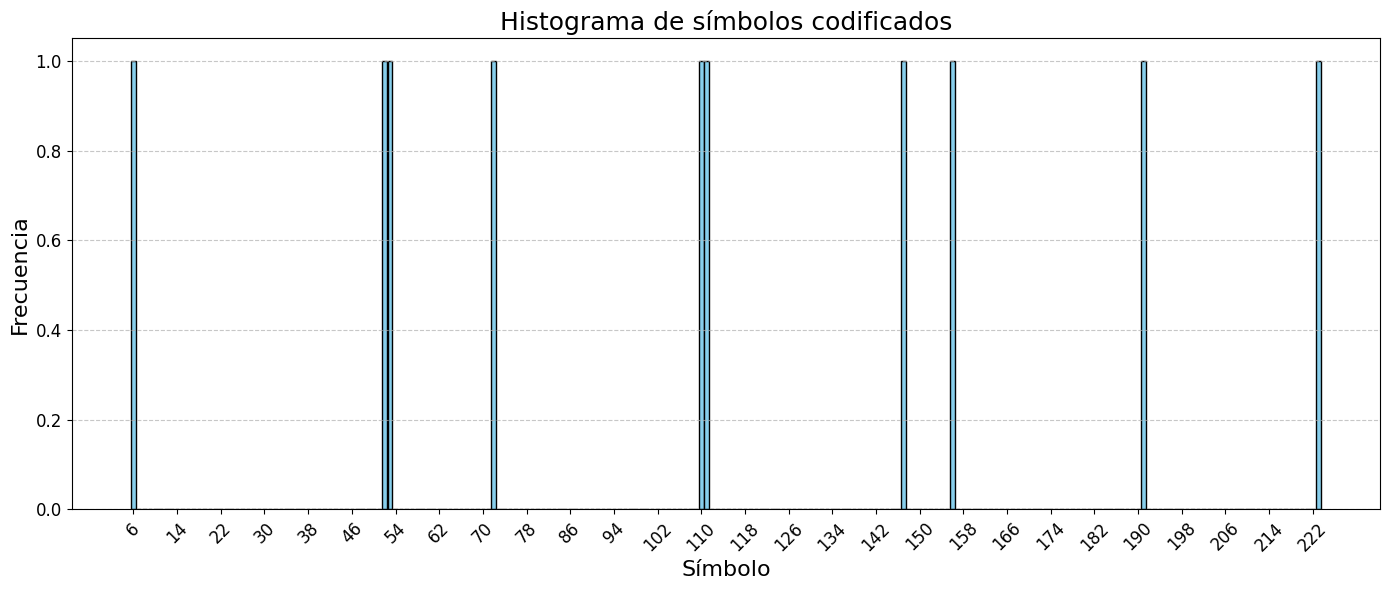

------------------------------
======== DECODIFICACION ========
Primeros 20 bits recibidos:  [0 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 0]
------------------------------
======== COMPARACION ========
Bits originales (muestra):    [0 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1]
Bits decodificados (muestra): [0 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1]
La tasa de error de bit (BER) es:  0.0 %
------------------------------


In [16]:
print("---" * 10)
print("=="*4,"GENERACION DE HIPOTESIS","=="*4)
bits_tx = generate_random_bits(TOTAL_BITS)
print("Primeros 20 bits a transmitir: ", bits_tx[0:20])
print("---" * 10)

print("=="*4,"CODIFICACION","=="*4)
simbolos = codificador(SF, bits_tx)
print("Cantidad de simbolos detectados: ", len(simbolos))
print("Primeros 10 simbolos: ", simbolos[0 : 10])
graficar_histograma(simbolos)
print("---" * 10)


print("=="*4,"DECODIFICACION","=="*4)
bits_rx = decodificador(simbolos, SF)
print("Primeros 20 bits recibidos: ", bits_rx[0:20])
print("---" * 10)

print("=="*4,"COMPARACION","=="*4)
print("Bits originales (muestra):   ", bits_tx[: 2 * SF])
print("Bits decodificados (muestra):", bits_rx[: 2 * SF])
print("La tasa de error de bit (BER) es: ", calculador_ber(bits_tx, bits_rx) * 100, "%")
print("---" * 10)


---

## 2. Conformador de onda y conformador de n-tuplas

### 2.1 Conformador de onda

El próximo paso en nuestro sistema de comunicación es el conformador de onda o waveform former, el cual es la etapa posterior al codificador y ambos componen el bloque del transmisor. El conformador de onda propuesto en [1] implementa la modulación **_Frequency Shift Chirp Modulation_ (FSCM)**.

En esta modulación, cada símbolo se asocia a una frecuencia inicial $s(nT_s)$. A partir de esta frecuencia, la señal modulada presenta un barrido lineal en frecuencia (tipo chirp), donde la frecuencia incrementa linealmente con el tiempo, siguiendo el índice $k=0, 1, … ,2^{SF}-1$, hasta alcanzar un valor máximo de $2^{SF}$.

Luego, la frecuencia decae hasta 0 y vuelve a incrementarse hasta volver al valor de $s(nT_s)$, completando así el periodo del símbolo $T_s$. Esta modulación al realizarse con una señal compleja, se compone de una componente real o fase (I) y otra componente imaginaria o cuadratura (Q). Esto se representa por la siguiente ecuación:

$$\Large c(nT_s + kT) = \frac{1}{\sqrt{2^{SF}}} \cdot e^{j2\pi[(s(nT_s)+k){\bmod{2^{SF}}}](kT\frac{B}{2^{SF}})}\quad k=0,...,2^{SF}-1$$

En la misma:

- Toma un símbolo codificado $𝑠∈{0, 1,...,2^{𝑆𝐹}−1}$
- Lo inserta como un shift de frecuencia inicial en una señal chirp.
- Genera una onda compleja cuya frecuencia aumenta linealmente en el tiempo (chirp) y comienza en una frecuencia determinada por **𝑠**.

$c(nT_s + kT)$ es una función que tiene dos argumentos constantes $T_s$ que representa el tiempo que dura un símbolo y $T$ que representa el periodo de muestreo dentro de cada símbolo. El primer argumento $kT$ nos dice dónde va a existir la señal (donde se muestrea).

Analizando las ecuaciones se pueden observar:

- $k$ Es el índice de tiempo discreto que varía la frecuencia linealmente.
- La frecuencia inicial (cuando $k=0$) viene dado por el valor del símbolo $s(nT_s)$
- El módulo de $(s(nT_s) + k)$ en base $2^{SF}$ tiene por fin limitar el crecimiento lineal de la frecuencia hasta un valor de frecuencia máximo $2^{SF}-1$ con el propósito de limitar el ancho de banda. Esta operación genera un discontinuidad en la frecuencia haciendo que la misma caiga desde el valor máximo hasta $0$ para luego continuar creciendo hasta el valor inicial $s(nT_s)$ finalizando el periodo $T_s$ del símbolo.

A continuación, se presenta el **conformador de onda**. Por cada símbolo codificado, genera su función chirps compleja, devuelve una matriz en la cual cada fila tiene los valores de la función chirp correspondiente a su símbolo, y en las columnas tiene los valores de esa función chirp en cada tiempo de muestreo


In [42]:
def conformador_de_onda(simbolos, SF, B=125e3):
    M = 2 ** SF
    k = np.arange(M)
    
    # fase del chirp LoRa
    fase_base = (k**2) / (2*M)

    upchirp = (1 / np.sqrt(M)) * np.exp(1j * 2 * np.pi * fase_base)

    # Matriz de Filas = cantidad de simbolos, y Columnas = Cantidad de Muestras
    waveform = np.zeros((len(simbolos), M), dtype=complex)

    for i, s in enumerate(simbolos):
        # desplazamiento de una cantidad a los valores de un array
        # aplica el modulo automaticamente
        waveform[i] = np.roll(upchirp, -s)

    return waveform

### 2.2 Formador de n-tuplas

Para recuperar el símbolo modulado se proyecta la señal recibida $r(nT_s + kT)$ en el conjunto de bases conjugadas con las que se moduló la señal, en nuestro caso la base con la que se modulo la señal está formada por una única señal $c(nT_s + kT)$. Por lo tanto, la proyección:

$$\langle r(nT_s+kT),c(nT_s+kT)|_{s(nT_s)=q} \rangle$$

$$=\sum_{k=0}^{2^{SF}-1}r(nT_s+kT)\, \cdot \, c^*(nT_s+kT)|_{s(nT_s)=q}$$

Se llega a la siguiente expresión:

$$=\sum_{k=0}^{2^{SF}-1}\underbrace{r(nT_s + kT) \cdot e^{-j2\pi \frac{k^2}{2^{\text{SF}}}}}_{d(nT_s + kT)}\, \cdot \,\frac{1}{\sqrt{2^{SF}}}e^{-j2\pi p k \frac{1}{2^{SF}}}$$

Reescribiendo el producto:
$$d(nT_s + kT)=r(nT_s + kT) \cdot e^{-j2\pi \frac{k^2}{2^{\text{SF}}}}$$

Se tiene:

$$\sum_{k=0}^{2^{SF}-1}d(nT_s + kT)\, \cdot \,\frac{1}{\sqrt{2^{SF}}}e^{-j2\pi p k \frac{1}{2^{SF}}}$$

La cual es la transformada de Fourier discreta de la señal $d(nT_s + kT)$


In [43]:
def up_chirp(SF, B = 125e3):
    # Generacion de un chirp base
    return conformador_de_onda([0], SF).flatten()

def down_chirp(SF, B = 125e3):
    # Calculo de su conjugado
    return np.conj(up_chirp(SF)).flatten()

In [44]:
def formador_de_ntuplas(simbolos_modulados, SF, B = 125e3):

    d_chirp = down_chirp(SF)
    
    d = simbolos_modulados * d_chirp # Multiplicacion explicada previamente
    
    # Aplicar FFT por filas definiendo axis=1
    D = np.fft.fft(d, axis=1)
    
    # Detectar el símbolo de cada fila
    symbols_rx = np.argmax(np.abs(D), axis=1)
    
    return symbols_rx


### 2.3 Symbol error rate (SER)

El _Symbol Error Rate_ (SER), similar al BER, representa la proporción de símbolos recibidos con error respecto al total de símbolos transmitidos. Se calcula de la siguiente forma:

$$SER=\frac{\text{número de símbolos erróneos}}{\text{total de símbolos transmitidos}}$$

Los símbolos que salen del **n-tuple former** y se comparan con los símbolos que entran al **waveform former**


In [45]:
def calculador_ser(simbolos_tx, simbolos_rx):
    """
    Calcula la tasa de error de símbolos (SER) entre los símbolos transmitidos y recibidos.

    Args:
        simbolos_tx (list): Arreglo unidimensional de símbolos transmitidos.
        simbolos_rx (list): Arreglo unidimensional de símbolos recibidos.

    Returns:
        SER (float): Tasa de error de símbolos (SER).
    """
    if len(simbolos_tx) != len(simbolos_rx):
        raise ValueError("Los arreglos de símbolos transmitidos y recibidos deben tener la misma longitud.")

    errores = np.sum(simbolos_tx != simbolos_rx)
    ser = errores / len(simbolos_tx)

    return ser


### 2.4 Grafica de Funciones

A continuación, se definen funciones para graficar las señales moduladas. La primera función grafica la función modulada de un solo símbolo tanto la parte real como la imaginaria.


In [46]:
def graficar_señal_modulada(simbolos_modulados, SF, B):
    """
    Grafica la señal modulada en tiempo (I y Q) de un símbolo dado por su índice dentro de la matriz de símbolos modulados.

    Args:
        simbolos_modulados (Array): Lista de símbolos modulados en forma de chirps.
        indice (int): Posición del símbolo que se desea graficar.
        SF (int): Spreading Factor.
        samples_per_chirp (int): Muestras por símbolo o factor de oversampling.
        B (int): Ancho de banda (Hz).
    """
    indice = 0
    Ns = 2**SF  # Muestras base por símbolo
    total_muestras = Ns # Muestras por símbolo
    T = 1 / B  # Muestra
    T_muestra =Ns* T # Duración de cada muestra (s)

    tiempo = np.arange(total_muestras) * T_muestra * 1e6  # Tiempo en microsegundos

    muestra_simbolo_mod = simbolos_modulados[indice]
    I = np.real(muestra_simbolo_mod)  # Componente en fase
    Q = np.imag(muestra_simbolo_mod)  # Componente en cuadratura

    # Grafica
    fig, axs = plt.subplots(2, 1, figsize=(15, 4), sharex=True)
    axs[0].plot(tiempo, I, color="blue", linewidth=0.9)
    axs[0].set_title(f"Chirp LoRa - Fase (I) - índice {indice} (SF={SF})")
    axs[0].set_ylabel("Amplitud")
    axs[0].grid()

    axs[1].plot(tiempo, Q, color="red", linewidth=0.9)
    axs[1].set_title(f"Chirp LoRa - Cuadratura (Q) - índice {indice} (SF={SF})")
    axs[1].set_xlabel("Tiempo [μs]")
    axs[1].set_ylabel("Amplitud")
    axs[1].grid()

    plt.tight_layout()
    plt.show()

La segunda función realiza la gráfica de la fase, pero para un grupo de símbolos


In [47]:
def graficar_todas_las_senales_moduladas(simbolos_modulados, SF, B):
    """
    Grafica la señal modulada completa solo de la parte en fase (I) concatenando los símbolos,
    y colorea cada símbolo con un color distinto.

    Args:
        simbolos_modulados (Array): Lista de símbolos modulados en forma de chirps.
        SF: Spreading Factor.
        samples_per_chirp: Muestras por símbolo o factor de oversampling.
        B: Ancho de banda (Hz).
        max_muestras: Cantidad de símbolos a graficar (opcional).
    """
    Ns = 2**SF
    total_muestras = Ns
    T = 1 / B
    T_muestra = Ns* T 
    max_muestras = len(simbolos_modulados)

    cmap = plt.get_cmap("tab10")

    plt.figure(figsize=(15, 3))

    for i in range(max_muestras):
        simbolo = simbolos_modulados[i]
        I = np.real(simbolo)
        tiempo_local = (np.arange(i * total_muestras, (i + 1) * total_muestras) * T_muestra * 1e6)
        plt.plot(tiempo_local, I, label=f"Símbolo {i}", color=cmap(i % 10), linewidth=0.6)

    plt.title(f"Fase (I) de todos los símbolos concatenados (SF={SF})")
    plt.xlabel("Tiempo [μs]")
    plt.ylabel("Amplitud")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Por último, se presenta la función que grafica el barrido lineal de frecuencia para un símbolo y para todos los símbolos enviados


In [48]:
def plot_lora_frequency_chirp(simbolos, SF=8, B=125e3):
    """
    Genera y grafica la frecuencia instantánea (chirp) del símbolo LoRa dado.

    Args:
        simbolo (int): lista de simbolos 
        indice (int): indice del simbolo a graficar
        sf (int): Spreading Factor (por defecto 7)
        Bw_kHz (float): Ancho de banda en kHz (por defecto 125)
    """
    # Parámetros 
    indice = 0
    s = simbolos[indice]
    Ns = 2**SF  # Numero de muestra
    Ts = Ns / B  # Duración del símbolo en segundos
    samples = Ns  # 1 muestra por paso
    t = np.linspace(0, Ts, samples)  # vector de tiempo

    # Cálculo de frecuencia instantánea
    f_inst = (s * B / Ns + (B / Ts) * t) % B
    f_inst_kHz = f_inst / 1e3
    t_ms = t * 1e3  # tiempo en milisegundos

    # Gráfico
    plt.figure(figsize=(12, 4))
    plt.title("LoRa Modulation - Chirp Frecuencia Instantánea", fontsize=16, weight="bold")
    plt.xlabel("Time [ms]", fontsize=14)
    plt.ylabel("Frequency [kHz]", fontsize=14)
    plt.plot(t_ms, f_inst_kHz, lw=2, color="deepskyblue")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


In [49]:
def plot_lora_frequency_chirps(simbolos, SF=8, B=125e3):
    """
    Genera y grafica la frecuencia instantánea (chirp) de una secuencia de símbolos LoRa.

    Args:
        simbolos (list or array): Secuencia de valores de símbolos LoRa (enteros entre 0 y 2^SF - 1)
        SF (int): Spreading Factor
        B (float): Ancho de banda en Hz
    """
    Ns = 2**SF # Número de muestras por símbolo
    Ts = Ns / B # Duración del símbolo en segundos
    samples = Ns # 1 muestra por paso
    t_total = []
    f_total = []

    for i, s in enumerate(simbolos):
        t = np.linspace(i * Ts, (i + 1) * Ts, samples, endpoint=False)
        f_inst = (s * B / Ns + (B / Ts) * (t - i * Ts)) % B
        t_total.append(t)
        f_total.append(f_inst)

    # Concatenar todo el tiempo y frecuencia
    t_total = np.concatenate(t_total) * 1e3 # a milisegundos
    f_total = np.concatenate(f_total) / 1e3 # a kHz

    # Graficar
    plt.figure(figsize=(12, 4))
    plt.title("LoRa Modulation - Frecuencia Instantánea", fontsize=16, weight="bold")
    plt.xlabel("Tiempo [ms]", fontsize=14)
    plt.ylabel("Frecuencia [kHz]", fontsize=14)
    plt.plot(t_total, f_total, lw=2, color="deepskyblue")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


### 2.5 Ejemplo

Se continua el proceso iniciado en el capítulo anterior agregando el **conformador de ondas** luego de la codificación de los bits, y agregando el **conformador de n-tuplas** antes del decodificador y realizando el cálculo del **SER**


------------------------------
======== WAVEFORM ========
Salida del conformador de onda: [ 0.04419417+4.41941738e-02j -0.06114484-1.29444610e-02j
  0.0588465 -2.10556158e-02j -0.04023947+4.78229541e-02j
  0.01219315-6.12990800e-02j  0.01740748+6.00269075e-02j
 -0.04197243-4.63094453e-02j  0.05744462+2.46245025e-02j
 -0.0625    +1.04118190e-15j  0.05803163-2.32073246e-02j
 -0.04630945+4.19724347e-02j  0.03013649-5.47543809e-02j
 -0.01219315+6.12990800e-02j -0.00536233-6.22695383e-02j
  0.02105562+5.88465041e-02j -0.03408281-5.23890441e-02j
  0.04419417+4.41941738e-02j -0.05153683-3.53582382e-02j
  0.05649933+2.67221933e-02j -0.05958163-1.88753718e-02j
  0.06129908+1.21931451e-02j -0.06211919-6.88888796e-03j
  0.06242472+3.06672965e-03j -0.06249529-7.66971143e-04j
  0.0625    -4.89858720e-16j -0.06249529-7.66971143e-04j
  0.06242472+3.06672965e-03j -0.06211919-6.88888796e-03j
  0.06129908+1.21931451e-02j -0.05958163-1.88753718e-02j
  0.05649933+2.67221933e-02j -0.05153683-3.53582382e-02

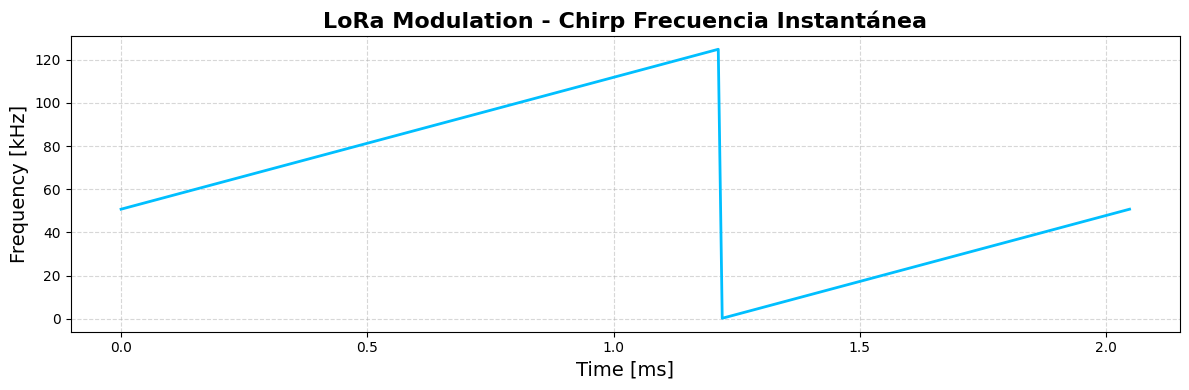

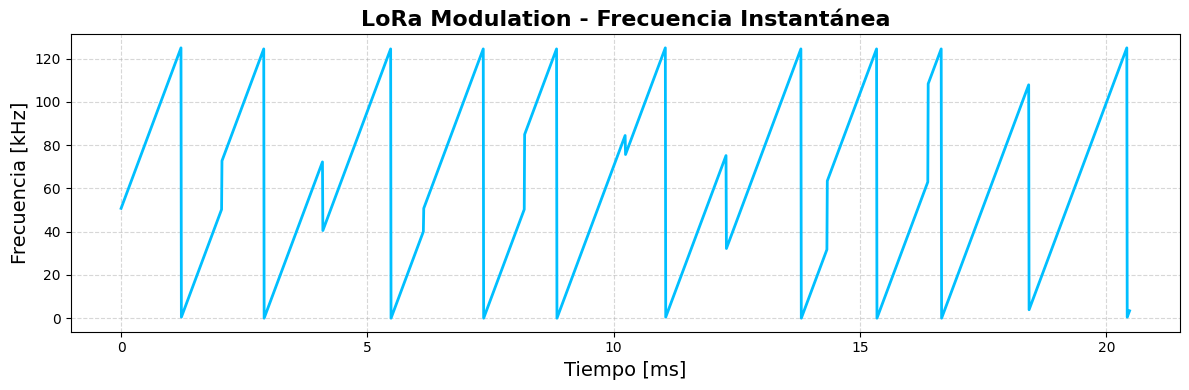

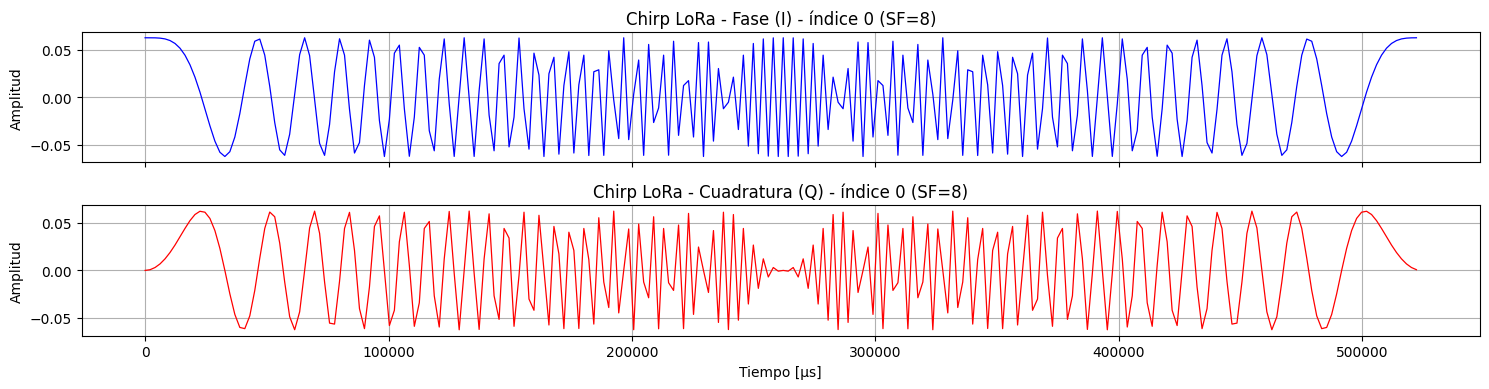

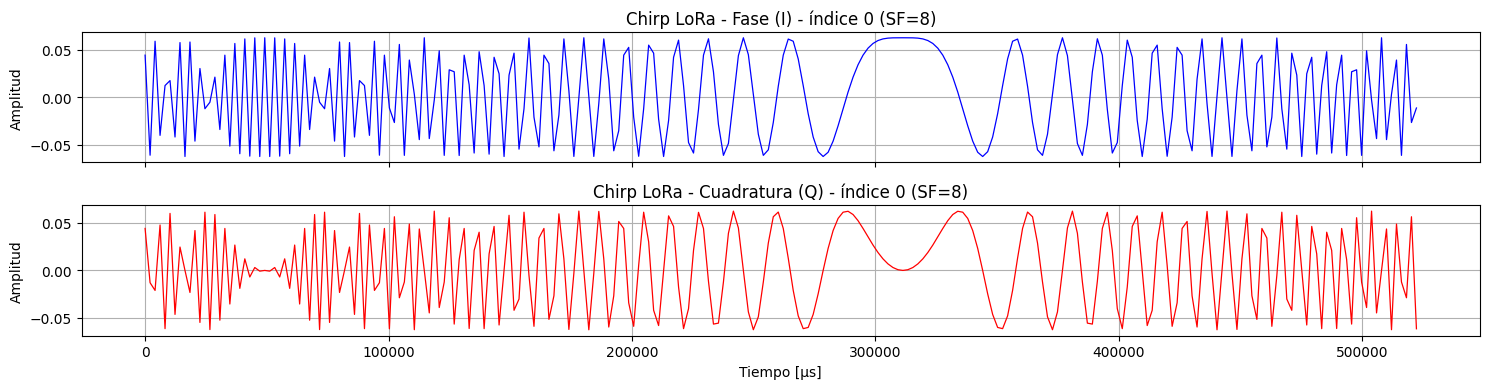

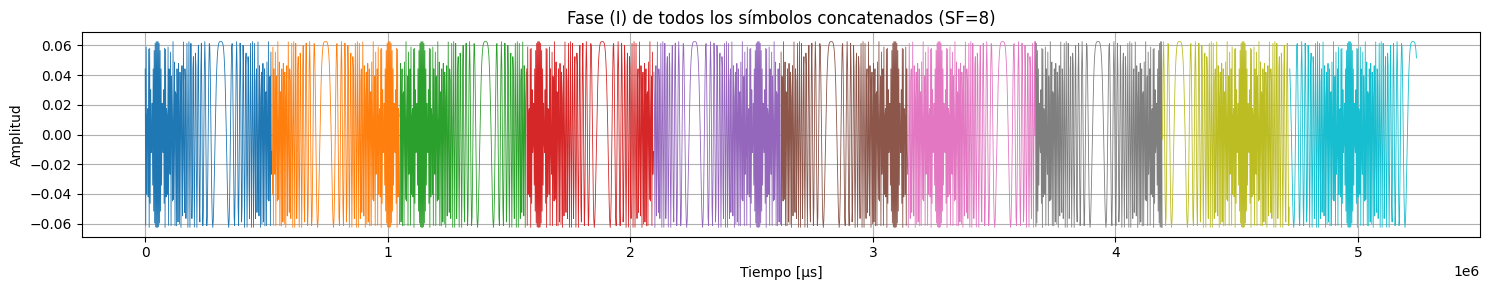

------------------------------
======== DEMODULACION ========
Salida del conformador de onda:  [104 149  83 104 174 155  66 130 222   8]
------------------------------
======== COMPARACION ========
Símbolos codificados: [104 149  83 104 174 155  66 130 222   8]
Símbolos recibidos: [104 149  83 104 174 155  66 130 222   8]
La tasa de error de simbolos (SER) es:  0.0 %
------------------------------


In [50]:
print("---" * 10)
simbolos_modulados = conformador_de_onda(simbolos, c.SF)
print("=="*4,"WAVEFORM","=="*4)
print("Salida del conformador de onda:", simbolos_modulados[0])

print("=="*4,"GRAFICAS","=="*4)
plot_lora_frequency_chirp(simbolos, c.SF)
plot_lora_frequency_chirps(simbolos, c.SF)

# Aca se nota como la parte real es un coseno y la imaginaria es un seno
s_test = [0]
s_mod_test = conformador_de_onda(s_test,c.SF)
graficar_señal_modulada(s_mod_test, c.SF, c.B)

graficar_señal_modulada(simbolos_modulados, c.SF, c.B)
graficar_todas_las_senales_moduladas(simbolos_modulados, c.SF, c.B)
print("---" * 10)

print("=="*4,"DEMODULACION","=="*4)
simbolos_rx = formador_de_ntuplas(simbolos_modulados, c.SF)
print("Salida del conformador de onda: ", simbolos_rx)
print("---" * 10)

print("=="*4,"COMPARACION","=="*4)
print("Símbolos codificados:", simbolos)
print("Símbolos recibidos:", simbolos_rx)
print("La tasa de error de simbolos (SER) es: ",calculador_ser(simbolos, simbolos_rx) * 100,"%",)
print("---" * 10)


---

## 3. Canal

En este apartado se utilizarán dos tipos de canales simulados

- Canal **AWGN**
- Canal **Selectivo en Frecuencia**

Con el fin de verificar y validar el funcionamiento del software desarrollado para posteriormente llevarlo a una implementación en un canal real


### 3.1 Canal AWGN

El primer canal a simular es el **canal AWGN** el cual suma un ruido blanco gaussiano a la señal transmitida, ruido que tiene una distribución normal con media cero y varianza $\sigma^2$. El modelo matemático típico de un canal AWGN es el siguiente:

$$r(nT_s+kT)=c(nT_s +kT)+w(nT_s +kT)$$

Donde:

- $𝑐(𝑛𝑇_𝑠+𝑘𝑇)$ : es la señal chirp transmitida para el símbolo $𝑠$
- $𝑤(𝑛𝑇_𝑠+𝑘𝑇)$ : es ruido blanco gaussiano complejo
- $r(nT_s+kT)$ : es la señal recibida

La señal transmitida es una secuencia de muestras complejas (un chirp), y a cada muestra le suma un valor complejo aleatorio.


#### 3.1.1 Obtención de la potencia del ruido a partir del SNR deseado

La potencia de una señal aleatoria $x$ se define como:

$$P_x = \mathbb{E}[|x|^2]$$

Donde $|x|^2 = x.x^*$, producto de $x$ por su conjugado.

Desarrollando la expresión:

$$P_x=\mathbb{E}[(x - \mu +\mu)^2] =\mathbb{E}[(x - \mu)^2] + |\mu|^2 + 2\cdot \mathbb{E}[x - \mu]$$

Donde:

$2\cdot \mathbb{E}[x - \mu]=2\cdot(\mathbb{E}[x]−\mathbb{E}[\mu])=2\cdot (\mu-\mu)=0$

$\mathbb{E}[(x - \mu)^2]=Var(x)$

Entonces:

$$P_x = \mathbb{E}[|x|^2]=\text{Var}(x) + |\mu|^2$$

Ecuación que utilizaremos para calcular la potencia de la señal transmitida

Si la media es cero ($\mu=0$):

$$P_x = \text{Var}(x) = \sigma^2$$

Ecuación utilizada para calcular la potencia de ruido al ser un canal AWGN

En AWGN, las partes real e imaginaria son independientes e idénticamente distribuidas cada una con varianza $\frac{\sigma^2}{2}$, si $x = a + jb$ entonces $P_x = Var(a) + Var(b)= \frac{\sigma^2}{2} + \frac{\sigma^2}{2}  = \sigma^2$

Para modelar el canal se utiliza un ruido complejo con distribución normal, cuya desviación estándar para la parte real e imaginaria que cumpla la descripción matemática anterior es:

$$\sigma = \sqrt{\frac{Potencia_{Ruido}}{2}}$$


In [51]:
def canal_AWGN(signal, pot_ruido):
    """
    Simula un canal AWGN. Con media cero y varianza pot_ruido/2.

    Args
        signal (array)
        pot_ruido (int)
    
    Return
        Señal + Ruido (array)
    """
    # el parametro que requiere la funcion random.normal es el desvio estandar, el cual es la raiz cuadrada de la potencia
    # la potencia es divida en 2 porque el ruido es complejo (I y Q)
    desv_est = np.sqrt(pot_ruido / 2)
    ruido = np.random.normal(0, desv_est, size=signal.shape) + 1j * np.random.normal(0, desv_est, size=signal.shape)
    return signal + ruido


La Relación Señal Ruido se define como $SNR = \frac{P_s}{P_n}$ siendo $P_s$ la potencia de la señal y $P_n$ la potencia del ruido. Para calcular la SNR en decibelios se utiliza la siguiente formula

$$\large \text{SNR}_{dB}=10\cdot log(\frac{P_s}{P_n})$$

Despejando, la potencia de Ruido se puede calcular realizando

$$\large P_n=\frac{P_s}{10^{\frac{\text{SNR}_{dB}}{10}}}$$


In [52]:
def potencias_de_ruido(pot_signal, lim_inf=-12, lim_sup=0):
    """
    Calcula el rango de potencias de ruido en escala lineal para un rango de SNR en dB.

    Args:
        pot_signal (float): Potencia de la señal en escala lineal.
        lim_inf (int, optional): Valor de SNR inferior. Defaults to -12.
        lim_sup (int, optional): Valor de SNR superior. Defaults to -1.

    Returns:
        list: lista de SNR en dB
        list: lista de potencias de ruido.
    """
    snr_db = np.arange(lim_inf, lim_sup + 1, 1)
    pot_ruido = pot_signal / (10 ** (snr_db / 10))
    return snr_db, pot_ruido


Se plantea una función la cual grafica la modulación chirp para un símbolo y se superpone con la misma chirp pero con el ruido del canal AWGN


#### 3.1.2 Canal Flat

La modulación FSCM está realizada sobre un **canal plano (Flat)** con la suma de ruido gaussiano blanco (AWGN). Un canal plano en frecuencia es un canal cuya respuesta en frecuencia es constante dentro del ancho de banda de la señal, no hay distorsión selectiva: todos los componentes de frecuencia de la señal se ven afectados igual.


### 3.2 Canal selectivo en frecuencia

El modelo de canal selectivo en frecuencia que se propone en [1] es un canal _multipath_ (de múltiples trayectorias) lo que este canal modela es que la señal rebota en objetos del entorno (paredes, árboles, etc.) y llega al receptor con varios retardos y distintas potencias, de esta manera distorsiona la señal, porque introduce interferencia Inter símbolo (ISI). La respuesta al impulso del canal matemáticamente:

$$h[nT]=\sqrt{0.8}\cdot\delta[nT]+\sqrt{0.2}\cdot\delta[nT-T]$$

Esto significa que el canal tiene dos trayectorias:

- Una señal principal (sin retardo) con ganancia $\sqrt{0.8}$
- Una segunda señal (retrasada 𝑇) con ganancia $\sqrt{0.2}$

Cuya transformada de Fourier continua es:

$$H(f)=\sqrt{0.8}+\sqrt{0.2}\cdot e^{-j2\pi f T}$$

Suponiendo $T=1$ tiempo normalizado

$$H(f)=\sqrt{0.8}+\sqrt{0.2}\cdot e^{-j2\pi f }$$

Se puede observar su efecto sobre señales para distintos valores de frecuencia:

|  f   | magnitud de H(f) |        Efecto        |
| :--: | :--------------: | :------------------: |
| 0.25 |        1         |  Sin interferencia   |
| 0.5  |       0.45       |  Maxima atenuación   |
| 0.75 |        1         |  Sin interferencia   |
|  1   |       1.34       | Maxima amplificación |


In [53]:
def canal_multipath(signal_in, pot_ruido):
    """
    Aplica el filtro h[n] = sqrt(0.8)δ[n] + sqrt(0.2)δ[n−1] a cada chirp (fila) y
    agrega ruido. Se recorta para mantener la longitud original sin relleno artificial.

    Args:
        signal_in (np.ndarray): Array (n_chirps, total_muestras)
        pot_ruido (float): Potencia del ruido (lineal)

    Returns:
        np.array: Señal con forma (n_chirps, total_muestras)
    """
    h = np.array([np.sqrt(0.8), np.sqrt(0.2)])
    chirps_filtrados = []

    for chirp in signal_in:
        chirp_filtrado = np.convolve(chirp, h, mode="full")[: len(chirp)]
        chirps_filtrados.append(chirp_filtrado)

    signal_filtrada = np.array(chirps_filtrados)

    # Agregar ruido complejo
    desv_est = np.sqrt(pot_ruido / 2)
    ruido = np.random.normal(0, desv_est, size=signal_filtrada.shape) + 1j * np.random.normal(0, desv_est, size=signal_filtrada.shape)

    return signal_filtrada + ruido


In [54]:
def graficar_chirp_con_y_sin_ruido(simbolos_modulados, SF, B, pot_ruido):

    indice = 0
    simbolo = simbolos_modulados[indice]
    simbolo_con_ruido = canal_AWGN(simbolo, pot_ruido)

    num_muestras = len(simbolo)
    Ts = (2**SF) / B
    T_muestra = Ts / num_muestras
    tiempo = np.arange(num_muestras) * T_muestra * 1e6  # μs

    sin_ruido = np.real(simbolo)
    con_ruido = np.real(simbolo_con_ruido)

    plt.figure(figsize=(12, 10))

    # -------------------------------------------------------------------------
    # SUBPLOT 1: CHIRP SIN RUIDO Y CON RUIDO
    # -------------------------------------------------------------------------
    plt.subplot(3,1,1)
    plt.plot(tiempo, sin_ruido, label='Sin Ruido', linewidth=1.2)
    plt.plot(tiempo, con_ruido, label='Con Ruido', linewidth=1.2, alpha=0.7)
    plt.title(f"Chirp LoRa - Parte Real - Índice {indice} (SF={SF})")
    plt.xlabel("Tiempo [μs]")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    # -------------------------------------------------------------------------
    # SUBPLOT 2: MAGNITUD Y FASE DEL CANAL (FFT)
    # -------------------------------------------------------------------------
    # Canal multipath: h[n] = sqrt(.8)δ[n] + sqrt(.2)δ[n-1]
    h = np.array([np.sqrt(0.8), np.sqrt(0.2)])
    
    # FFT de 512 puntos
    H = np.fft.fft(h, 512)
    frequencies = np.fft.fftfreq(len(H))

    # Solo mitad positiva
    freqs_pos = frequencies[:256]
    H_pos = H[:256]

    # Magnitud y Fase en SUBPLOT 2
    plt.subplot(3,1,2)
    plt.plot(freqs_pos, np.abs(H_pos), label="Magnitud |H(f)|", color="blue")
    plt.plot(freqs_pos, np.angle(H_pos), label="Fase ∠H(f)", color="orange")
    plt.title("Respuesta en frecuencia del canal selectivo (magnitud y fase)")
    plt.xlabel("Frecuencia Normalizada")
    plt.ylabel("Magnitud / Fase [rad]")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    # -------------------------------------------------------------------------
    # SUBPLOT 3: RESPUESTA AL IMPULSO (stem)
    # -------------------------------------------------------------------------
    plt.subplot(3,1,3)
    plt.stem(np.arange(len(h)), h)
    plt.title("Respuesta al impulso del canal multipath")
    plt.xlabel("n (muestras)")
    plt.ylabel("Amplitud")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [55]:
def simulaciones_de_canal(bits_tx,SF,B,min_snr_AWGN,max_snr_AWGN,min_snr_multipath,max_snr_multipath,):
    """
    Simula el envio de bits a traves de un canal multipath, grafica la BER vs SNR
    
    Args:
        bits_tx (list): Bits a transmitir.
        SF (int): Spreading Factor.
        samples_per_chirp (int): Muestras por chirp o factor de oversampling.
        B (int): Ancho de banda en Hz.
        min_snr (int): SNR mínima en dB.
        max_snr (int): SNR máxima en dB.
    """
    # 1. Codificacion
    simbolos_tx = codificador(SF, bits_tx)

    # 2. Modulacion
    simbolos_modulados = conformador_de_onda(simbolos_tx, SF, B)

    # 3. Calcular potencia de la señal
    pot_signal = np.var(simbolos_modulados) + (np.mean(np.abs(simbolos_modulados))) ** 2

    # 4. Generar SNR y potencias de ruido
    snr_db_AWGN, pot_ruido_AWGN = potencias_de_ruido(pot_signal, min_snr_AWGN, max_snr_AWGN)
    snr_db_multipath, pot_ruido_multipath = potencias_de_ruido(pot_signal, min_snr_multipath, max_snr_multipath)

    # 5. Simular canal y demodular para cada SNR
    ber_values_AWGN = []
    ber_values_multipath = []
    i = 1
    print("---"*10)
    print("BER VS CANAL AWGN")
    for pn in pot_ruido_AWGN:
        simbolos_con_ruido_AWGN = canal_AWGN(simbolos_modulados, pn)
        simbolos_rx_AWGN = formador_de_ntuplas(simbolos_con_ruido_AWGN, SF)
        bits_rx_AWGN = decodificador(simbolos_rx_AWGN, SF)
        ber_AWGN = calculador_ber(bits_tx, bits_rx_AWGN)
        print(f" Punto {i} - BER: {ber_AWGN}")
        ber_values_AWGN.append(ber_AWGN)
        i += 1
    print("---"*10)
    print("BER VS CANAL SELECTIVO EN FRECUENCIA")
    j = 1
    for pn in pot_ruido_multipath:
        simbolos_con_ruido_multipath = canal_multipath(simbolos_modulados, pn)
        simbolos_rx_multipath = formador_de_ntuplas(simbolos_con_ruido_multipath, SF)
        bits_rx_multipath = decodificador(simbolos_rx_multipath, SF)
        ber_multipath = calculador_ber(bits_tx, bits_rx_multipath)
        print(f"Punto {j} - BER: {ber_multipath}")
        ber_values_multipath.append(ber_multipath)
        j += 1
    print("---"*10)
    # 6. Graficar
    plt.figure(figsize=(6, 4))
    plt.semilogy(snr_db_AWGN, ber_values_AWGN, "s-r", label="Flat FSCM", linewidth=0.8)
    plt.semilogy(snr_db_multipath, ber_values_multipath, "D-b", label="Freq. sel. FSCM", linewidth=0.8)
    plt.xlim(-12, -1)
    plt.ylim(10**-5, 10**-1)
    plt.xticks(np.arange(-12, 0, 1))
    plt.title("BER vs SNR")
    plt.xlabel("SNR [dB]")
    plt.ylabel("BER")
    plt.grid(True, linestyle="--", which="both")
    plt.legend()
    plt.tight_layout()
    plt.show()


### 3.3 Ejemplo

Para empezar, se grafica la modulación chirp para un símbolo especifico y se superpone al mismo chirp pero con el ruido del canal AWGN

In [56]:
# Calcular potencia de señal y obtener potencia de ruido
pot_signal = np.mean(np.abs(simbolos_modulados[0])**2)
_, pot_ruidos = potencias_de_ruido(pot_signal, lim_inf=0, lim_sup=0)
pot_ruido = pot_ruidos[0] 


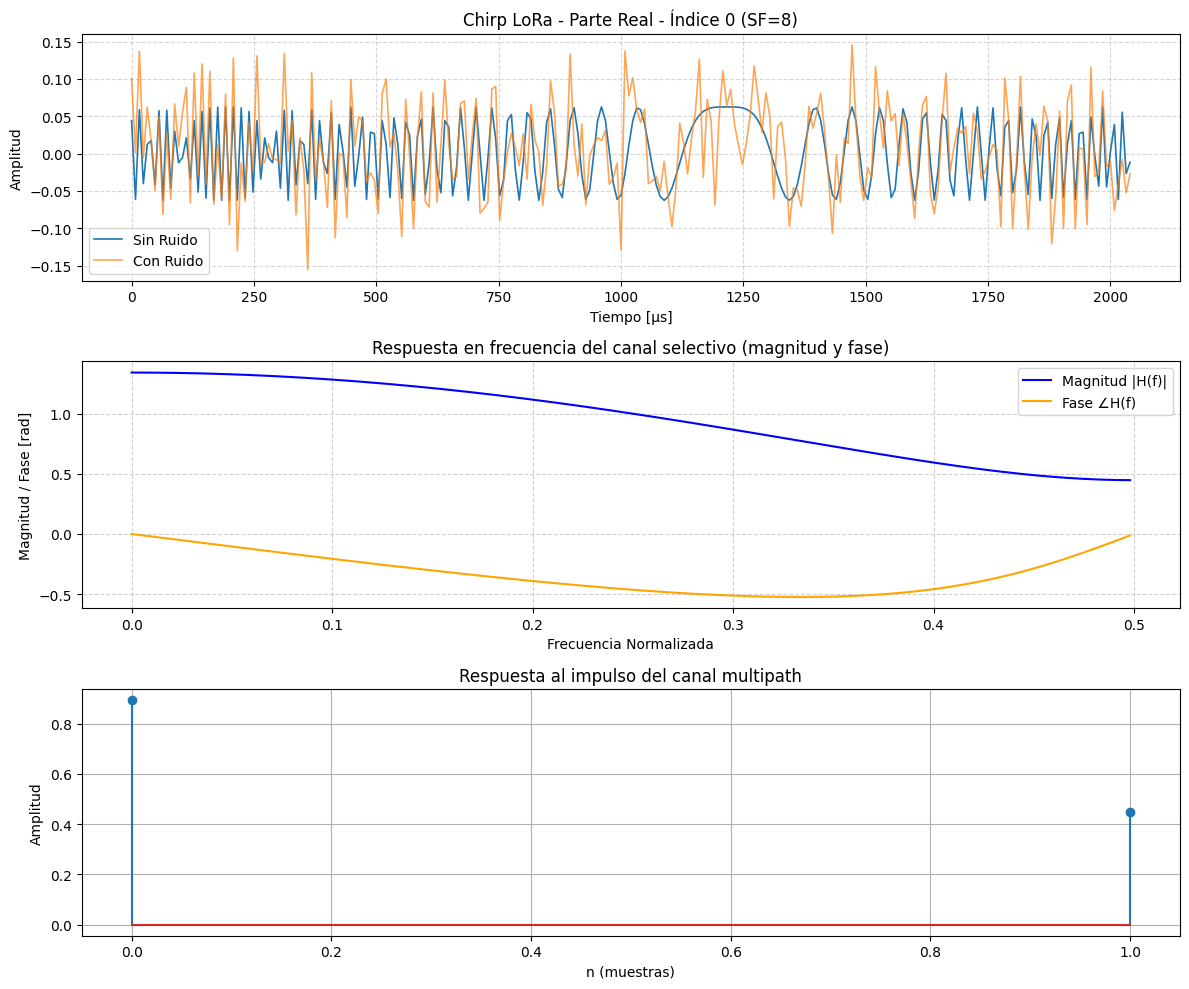

In [57]:
graficar_chirp_con_y_sin_ruido(simbolos_modulados, c.SF, c.B, pot_ruido)


Ahora sí, se simularan ambos canales AWGN y Selectivo en frecuencia, se realiza la gráfica del BER vs SNR

In [58]:
# Configuración/Parametros
cant_simbolos = 50000
total_bits = c.SF * cant_simbolos


In [59]:
# Generación de bits aleatorios
bits_tx = generate_random_bits(total_bits)


------------------------------
BER VS CANAL AWGN
 Punto 1 - BER: 0.02764
 Punto 2 - BER: 0.0082175
 Punto 3 - BER: 0.0011225
 Punto 4 - BER: 6.25e-05
------------------------------
BER VS CANAL SELECTIVO EN FRECUENCIA
Punto 1 - BER: 0.0309025
Punto 2 - BER: 0.011315
Punto 3 - BER: 0.0039775
Punto 4 - BER: 0.00168
Punto 5 - BER: 0.00055
Punto 6 - BER: 0.0001825
Punto 7 - BER: 4.5e-05
------------------------------


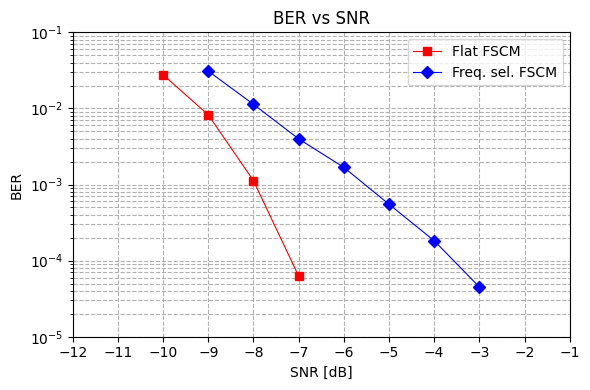

In [60]:
# Simulación del canal AWGN y multipath y graficar BER vs SNR
simulaciones_de_canal(bits_tx, c.SF, c.B, -10, -7, -9, -3)


<div align="center">

![Grafica Referencia](https://github.com/user-attachments/assets/d91ca973-45d0-4369-8133-0477a6c81c79)

</div>



En esta gráfica vemos la relación entre la tasa de bit errados vs la relación señal ruido en db. 

- Una $SNR_{db} = 0$ indica que la potencia de la señal es igual a la potencia de ruido del canal. 

- Una $SNR_{db} < 0$ indica que la potencia de ruido del canal es mayor que la potencia de la señal, lo que vemos que influye en la tasa de bits errados al momento de la recepción.

En [1] se realiza la comparación de la modulación FSCM contra la modulación FSK, y se observa que en el canal con ruido blanco gaussiano, no hay diferencia entre estas dos modulaciones al momento de aumentar la potencia de ruido y comparar su tasa de error. El beneficio de la modulación FSCM contra la FSK se observa al momento de compararlas en un canal selectivo en frecuencia, la modulación de LoRa es mucho más tolerante al a errores debido al ruido en comparación de la modulación FSK.


## 4. Demodulacion en entornos reales

Luego de validar y verificar el funcionamiento teórico de nuestro software, a continuación abordamos inconvenientes que surgen en la implementación física de esta tecnologia en los procesos de demodulacion y decodificacion.

#### 4.0.1 Definiciones

A continuacion se realizan algunas definiciones utiles:

##### 4.0.1.1 PHY (Physical Layer Protocol / Protocolo de Capa Física)

La Capa Física (PHY) es el protocolo que define cómo se transmiten los datos a través del medio físico (el aire, en el caso de la comunicación inalámbrica). El PHY es el conjunto de reglas y mecanismos que rigen la parte más básica de la comunicación: cómo se convierten los datos digitales (bits) en señales físicas (ondas de radio, chirps) y cómo se reciben y decodifican esas señales. Es la base de la comunicación LoRa. La PHY de LoRa es la responsable de la modulación Chirp Spread Spectrum (CSS) y se divide en dos pasos principales: la demodulación y la decodificación

##### 4.0.1.2 CRC (Cyclic Redundancy Check / Verificación de Redundancia Cíclica)

El CRC es un mecanismo utilizado en las tramas de datos para detectar si ha habido errores durante la transmisión de los datos. El CRC es un código de verificación de errores que se añade al paquete de datos para confirmar que los datos recibidos son idénticos a los datos transmitidos. En LoRa, los símbolos de datos incluyen el payload y opcionalmente el payload CRC. El CRC ocupa 16 bits (2 bytes) al final de un paquete y solo se aplica al payload (los datos de usuario), no al encabezado (header)

##### 4.0.1.3 CFO (Carrier Frequency Offset / Desplazamiento de Frecuencia de Portadora)

El CFO es un error de frecuencia que ocurre en la comunicación inalámbrica. El CFO es una discrepancia o desajuste en la frecuencia utilizada por el transmisor y el receptor. Esencialmente, el reloj del receptor no coincide exactamente con el reloj del transmisor.
- **Causa y Efecto**: El CFO es causado por las inestabilidades o imprecisiones de los osciladores en los dispositivos de bajo costo. Este desplazamiento hace que la señal de un chirp se desplace en el dominio de la frecuencia, lo que dificulta la alineación precisa de la ventana de demodulación y puede conducir a errores.
- **Relación con la Recuperación de Reloj:** El CFO está intrínsecamente relacionado con el Desplazamiento de Frecuencia de Muestreo (SFO) y la deriva de bin (bin drift) que debe corregirse en la etapa de Recuperación de Reloj (Clock Recovery)

### 4.1 Estructura de un paquete en la capa física LoRa

Los paquetes están compuestos de unidades básicas, en este caso los chirps (up-chirp, down-chirp o chirp modulados). Generalmente un paquete consta de tres partes:

#### 4.1.1 Preambulo

El preámbulo es una secuencia de **up-chirps base** (típicamente 8) que cumple funciones críticas:

- **Sincronización**: El preámbulo es una secuencia de up-chirps base (típicamente 8). Su propósito es permitir que el receptor detecte la presencia de un paquete LoRa y se utilice para la alineación de ventana (Window Alignment)
- **Estimación de Canal**: Facilita la sincronización temporal y estimación de parámetros

**Características técnicas:**

- Consiste en $N_p$ up-chirps base (por defecto 8)
- Cada up-chirp corresponde al símbolo $s = 0$
- Señal matemática:

$$
c_{base}(k) = \frac{1}{\sqrt{2^{SF}}} \cdot e^{j  \cdot  2\pi \cdot \frac{k^2}{2^{SF}}} \text{Para k = 0, 1, ..., } 2^{SF}
$$

#### 4.1.2 SFD (Start Frame Delimiter)

El SFD actúa como **marcador de inicio** de los datos:

- **Función**: Actúa como marcador de inicio de los datos. El SFD indica el comienzo de los símbolos de datos. La implementación avanzada de demodulación utiliza el SFD, junto con el preámbulo, para la alineación precisa de la ventana de demodulación y la eliminación del impacto del **CFO** (Carrier Frequency Offset)
- **Estructura**: Consiste en **2.25 down-chirps**
  - 2 down-chirps completos
  - 1/4 de down-chirp adicional
- **Señal**: Down-chirp = conjugado del up-chirp

**Total de muestras del SFD**: $2.25 \cdot 2^{SF} = 2 \cdot 2^{SF} + \frac{2^{SF}}{4}$


#### 4.1.3 Símbolos de Datos (Payload)

Los símbolos de datos son la parte final del paquete LoRaque contienen la información útil:

- **Contenido:** Los símbolos de datos incluyen el PHY Header, el Payload (datos del usuario), y el CRC (payload CRC)
- El header y el CRC son opcionales. En el modo explícito, hay un header PHY en el paquete, mientras que en el modo implícito no lo hay
- La información codificada (s) en estos símbolos se representa por el desplazamiento cíclico de la frecuencia inicial de un up-chirp base

In [61]:
def upchirp(SF, T=1, Bw=1):
    M_local = 2**SF  
    sobremuestreo = 1/(Bw*T)
    k = np.arange(M_local*sobremuestreo)
    fase = (k/sobremuestreo) * (k*T*Bw) / M_local
    chirp = (1 / np.sqrt(M_local)) * np.exp(1j * 2 * np.pi * fase)
    return chirp

In [62]:
def downchirp(SF, T=1, Bw=1):
    return np.conj(upchirp(SF, T, Bw))

In [63]:
def build_tx_frame(simbolos_data, SF, preamble_len=8):
    M  = 2**SF # numero de muestras   
    k = np.arange(M) # Instantes de muestreo
    fase = (k**2) / M # Fase del up-chirp
    up_chirp = upchirp(SF)
    # Upchirp base para dechirp
    dechirp = downchirp(SF)

    # preámbulo: Np up-chirps
    pre = np.tile(up_chirp, preamble_len) #Repite el up-chirp 'preamble_len' veces

    # SFD: 2 + 1/4 down-chirps (2.25)
    sfd = np.concatenate([np.tile(dechirp, 2), dechirp[:M//4]]) #repite 2 veces el down-chirp y luego agrega un cuarto de down-chirp

    # payload (matriz símbolos -> vector)
    payload = conformador_de_onda(simbolos_data,SF).flatten()          

    trama = np.concatenate([pre, sfd, payload]) # Concatenamos para armar la trama

    return trama

In [64]:
def visualizar_estructura_trama(frame, simbolos_data, SF, preamble_len=8):
    """
    Visualiza la estructura de una trama LoRa, mostrando las secciones de preámbulo, SFD y payload,
    tanto en el dominio temporal como en la frecuencia instantánea.

    Args:
        frame (array): Trama LoRa completa.
        simbolos_data (array): Símbolos de datos (payload).
        SF (int): Spreading Factor.
        preamble_len (int): Longitud del preámbulo en chirps (por defecto 8).
    """
    M = 2**SF  # Número de muestras por chirp (dependiente de SF)

    # Calcular longitudes de cada sección
    len_preamble = preamble_len * M
    len_sfd = int(2.25 * M)  # SFD: 2.25 chirps
    len_payload = len(simbolos_data) * M
    len_total = len_preamble + len_sfd + len_payload

    # Índices de delimitación
    idx_sfd_start = len_preamble
    idx_payload_start = len_preamble + len_sfd

    # Verificar longitud de la trama
    print("---" * 10)
    print("ESTRUCTURA TEORICA DE LA TRAMA LoRa")
    print(f"SF = {SF}, M = {M}")
    print("---" * 10)
    print(f"\nLongitudes esperadas:")
    print(f"Preámbulo ({preamble_len} up-chirps): {len_preamble} muestras")
    print(f"SFD (2.25 down-chirps):  {len_sfd} muestras")
    print(f"Payload ({len(simbolos_data)} símbolos): {len_payload} muestras")
    print(f"TOTAL: {len_total} muestras")
    print("---" * 10)
    print("ESTRUCTURA REAL DE LA TRAMA LoRa")
    print(f"\nLongitud real de la trama: {len(frame)} muestras")
    print(f"Diferencia: {len(frame) - len_total} muestras")
    print(f"\nSímbolos del payload: {simbolos_data}")
    print("---" * 10)

    # GRÁFICO 1: Estructura temporal completa (parte real)
    fig, ax = plt.subplots(figsize=(15, 4))
    fig.patch.set_facecolor('black')  # Fondo negro para toda la figura
    ax.set_facecolor('black')  # Fondo negro para el área del gráfico

    t = np.arange(len(frame))  # Vector de tiempo
    ax.plot(t, np.real(frame), linewidth=0.5, color='blue')  # Parte real de la trama

    # Marcadores verticales para las secciones
    ax.axvline(idx_sfd_start, color='red', linestyle=':', linewidth=2, label='Inicio SFD')
    ax.axvline(idx_payload_start, color='green', linestyle=':', linewidth=2, label='Inicio Payload')

    # Sombreado de regiones
    ax.axvspan(0, idx_sfd_start, alpha=0.4, color='cyan', label='Preámbulo')
    ax.axvspan(idx_sfd_start, idx_payload_start, alpha=0.4, color='yellow', label='SFD')
    ax.axvspan(idx_payload_start, len(frame), alpha=0.4, color='lightgreen', label='Payload')

    # Etiquetas y título
    ax.set_xlabel('Muestras', color='white')
    ax.set_ylabel('Amplitud (Parte Real)', color='white')
    ax.set_title('Estructura Completa de la Trama LoRa', color='white')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', facecolor='black', edgecolor='white', labelcolor='white')
    ax.tick_params(colors='white')  # Cambiar color de los ejes
    plt.tight_layout()
    plt.show()

    # GRÁFICO 2: Frecuencia instantánea de toda la trama
    fase = np.unwrap(np.angle(frame))  # Desenvuelve la fase
    frec_inst = np.diff(fase) / (2 * np.pi)  # Calcula la frecuencia instantánea

    fig, ax = plt.subplots(figsize=(15, 5))
    fig.patch.set_facecolor('black')  # Fondo negro para toda la figura
    ax.set_facecolor('black')  # Fondo negro para el área del gráfico

    t_frec = np.arange(len(frec_inst))  # Vector de tiempo para frecuencia instantánea
    ax.plot(t_frec, frec_inst, linewidth=1, color='blue')  # Frecuencia instantánea

    # Marcadores verticales para las secciones
    ax.axvline(idx_sfd_start, color='red', linestyle='--', linewidth=2, label='Inicio SFD')
    ax.axvline(idx_payload_start, color='green', linestyle='--', linewidth=2, label='Inicio Payload')

    # Sombreado de regiones
    ax.axvspan(0, idx_sfd_start, alpha=0.15, color='cyan')
    ax.axvspan(idx_sfd_start, idx_payload_start, alpha=0.15, color='yellow')
    ax.axvspan(idx_payload_start, len(frame), alpha=0.15, color='lightgreen')

    # Anotaciones para cada sección
    ax.text(len_preamble / 2, ax.get_ylim()[1] * 0.9, 'PREÁMBULO\n(up-chirps)', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='cyan', alpha=0.5))
    ax.text(idx_sfd_start + len_sfd / 2, ax.get_ylim()[1] * 0.9, 'SFD\n(down-chirps)', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
    ax.text(idx_payload_start + len_payload / 2, ax.get_ylim()[1] * 0.9, 'PAYLOAD\n(datos)', ha='center', va='top',
            fontsize=10, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

    # Etiquetas y título
    ax.set_xlabel('Muestras', color='white')
    ax.set_ylabel('Frecuencia Normalizada [ciclos/muestra]', color='white')
    ax.set_title('Frecuencia Instantánea - Verificación de Estructura LoRa', color='white')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', facecolor='black', edgecolor='white', labelcolor='white')
    ax.tick_params(colors='white')  # Cambiar color de los ejes
    plt.tight_layout()
    plt.show()

#### 4.1.4 Ejemplo de armado de tramas

In [65]:
SF = 8  # Spreading Factor (debe ser un valor entre 7 y 12)
cant_simbolos = 10  # Cantidad de símbolos a transmitir
total_bits = SF * cant_simbolos  # Total de bits a transmitir

In [66]:
# Generación de bits aleatorios
bits_tx = generate_random_bits(total_bits)
print("---" * 10)
print("Primeros 20 bits a transmitir: ", bits_tx[0:20])
print("---" * 10)

------------------------------
Primeros 20 bits a transmitir:  [0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 1]
------------------------------


In [67]:
simbolos = codificador(SF, bits_tx)
print("---" * 10)
print("Cantidad de simbolos detectados: ", len(simbolos))
print("Primeros 10 simbolos: ", simbolos[0 : 10])
print("---" * 10)

------------------------------
Cantidad de simbolos detectados:  10
Primeros 10 simbolos:  [192 114  92 230 111  40  42 237 115  54]
------------------------------


Generando trama de prueba...
------------------------------
ESTRUCTURA TEORICA DE LA TRAMA LoRa
SF = 8, M = 256
------------------------------

Longitudes esperadas:
Preámbulo (8 up-chirps): 2048 muestras
SFD (2.25 down-chirps):  576 muestras
Payload (10 símbolos): 2560 muestras
TOTAL: 5184 muestras
------------------------------
ESTRUCTURA REAL DE LA TRAMA LoRa

Longitud real de la trama: 5184 muestras
Diferencia: 0 muestras

Símbolos del payload: [192 114  92 230 111  40  42 237 115  54]
------------------------------


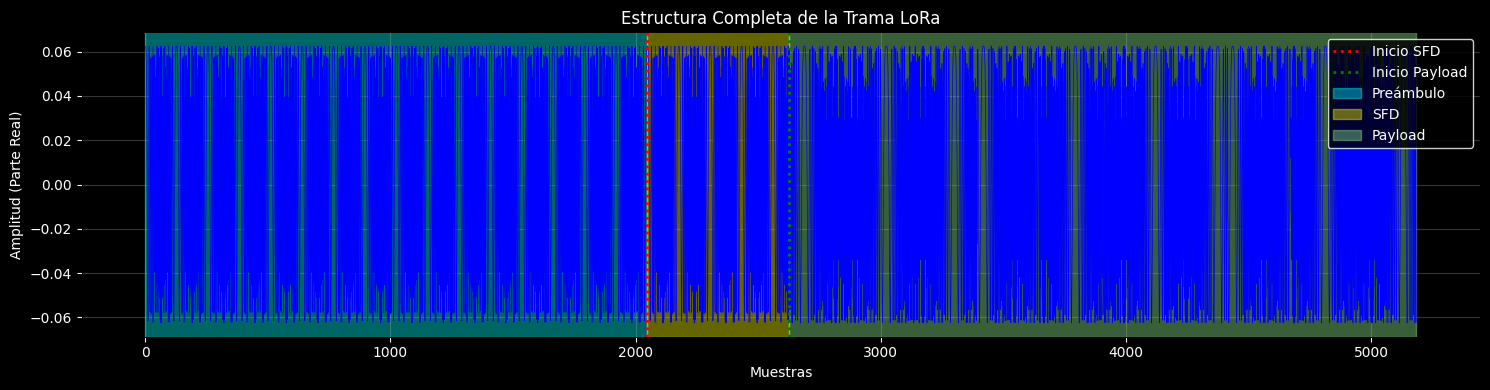

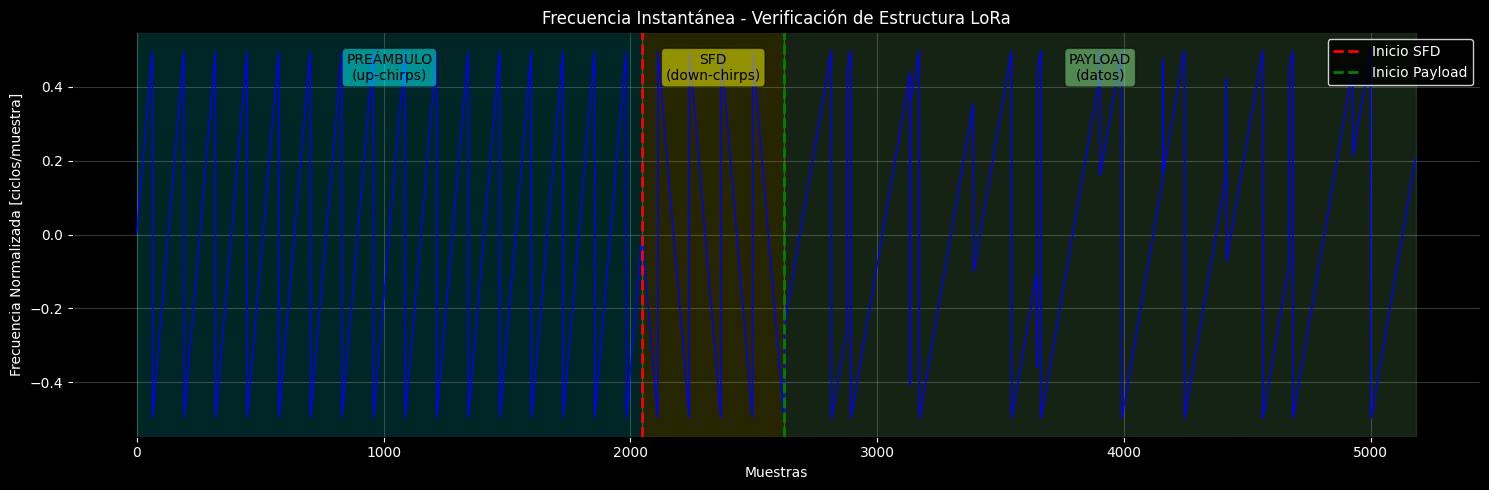

In [68]:
print("Generando trama de prueba...")
trama_test = build_tx_frame(simbolos, SF, preamble_len=8)
visualizar_estructura_trama(trama_test, simbolos, SF, preamble_len=8)

### 4.2 Desalineamiento de ventana

Mientras que el modelo teórico ideal asume una sincronización perfecta entre transmisor y receptor, en la práctica, el receptor debe determinar exactamente dónde comienza cada símbolo para alinear su ventana de muestreo y capturar completamente un chirp. El método estándar para sincronizar la ventana de recepción consiste en detectar el preámbulo, que es una secuencia de chirps base ascendentes. Sin embargo, este método falla en lograr una precisión a nivel de muestra debido al desplazamiento en frecuencia de la portadora (CFO).

El CFO es un desplazamiento en frecuencia causado por la inestabilidad de los osciladores, típico en dispositivos de bajo coste como los de IoT. En un chirp lineal, un desplazamiento en frecuencia es matemáticamente indistinguible de un desplazamiento en el tiempo. Si la señal llega con un CFO positivo, el pico de correlación del preámbulo se moverá, haciendo que el receptor crea que el símbolo llegó antes o después de lo que realmente lo hizo. Por lo tanto si solo se usa el preámbulo, el receptor alineará su ventana basándose en información "engañosa", resultando en un Desplazamiento Temporal (TO) residual.

Para resolver este problema [2] propone utilizar el ultimo up-chirp del preámbulo en conjunto con el primer down-chirp del delimitador de inicio de trama (SFD). Este método aprovecha la simetría inversa de los chirps:



- Al último up-chirp del preámbulo lo multiplica por un down-chirp base, obteniendo un pico en una frecuencia $f_1$. Dado que la pendiente del chirp es positiva, el error de tiempo (TO) resta valor a la frecuencia observada: $f_1 = \text{CFO} - \frac{B}{T} \cdot \text{TO}$.

- Al primer down-chirp del SFD lo multiplica por un up-chirp base, obteniendo un pico en una frecuencia $f_2$. Debido a que la pendiente es negativa, el mismo error de tiempo ahora suma valor a la frecuencia observada: $f_2 = \text{CFO} + \frac{B}{T} \cdot \text{TO}$.

<div align="center">

![Alineacion de Ventana](https://github.com/user-attachments/assets/727d8f1e-f4b2-405e-88f7-96ceb6958eed)

</div>

De esta manera, el receptor obtiene un sistema de dos ecuaciones donde el CFO actúa como una constante común y el TO actúa con signo opuesto. Al restar ambas frecuencias ($f_2 - f_1$), el término CFO se cancela automáticamente, aislando el error de tiempo para corregir la ventana de muestreo con precisión exacta:

$$\text{TO} = \frac{(f_2 - f_1)}{2} \cdot \frac{T}{B}$$


In [69]:
def cortar_en_chirps(trama, SF):
    M = 2**SF
    num_chirps = len(trama) // M
    chirps = trama[:num_chirps*M]    # recorta exceso
    return chirps.reshape(num_chirps, M)

In [70]:
def calculo_TO(trama, SF, preamble_len=8, T = 1, B = 1):
    to = 0
    M = 2**SF 
    k = np.arange(M) 
    fase = (k**2) / M
    upchirp = (1 / np.sqrt(M)) * np.exp(1j * 2 * np.pi * fase)
    dechirp = np.conj(upchirp) # Upchirp base para dechirp
    
    # Cortar la trama en chirps completos
    chirps = cortar_en_chirps(trama, SF)   
    # Índices
    idx_pre = preamble_len - 1 # obtengo el ultimo chirp del preambulo
    idx_sfd = idx_pre+1  # solo chirps completos (ignorar el 0.25)

    ultimo_up = chirps[idx_pre]
    primer_down = chirps[idx_sfd]
    
    f1 = ultimo_up * dechirp
    f2 = primer_down * upchirp
    fft_f1 = np.fft.fft(f1)
    fft_f2 = np.fft.fft(f2)
    f1_estimada = int(np.argmax(np.abs(fft_f1)))
    f2_estimada = int(np.argmax(np.abs(fft_f2)))
    
    to = ((f2_estimada-f1_estimada)/2)*(T/B)
    
    return to

In [71]:
To = calculo_TO(trama_test,SF)
print(f"Time Offset para caso Ideal: {To}")

Time Offset para caso Ideal: 0.0


### 4.3 Distorsión de picos en frecuencia

Mientras que el modelo teórico ideal asume que el símbolo LoRa mantiene una fase continua durante toda su duración, en la práctica, la transición abrupta de frecuencia (el "drop" de $B$ a $0$) introduce un salto de fase aleatorio e inevitable. 

El método estándar de demodulación muestrea la señal a una tasa igual al ancho de banda ($F_s = B$). Bajo estas condiciones, el segundo segmento del chirp cuya frecuencia inicial es $f_0 - B$ sufre aliasing o repliegue espectral. Matemáticamente, esto provoca que el segundo segmento se pliegue y caiga exactamente sobre la misma frecuencia que el primer segmento ($f_0$). Sin embargo, este método falla gravemente en condiciones de bajo SNR debido a la falta de coherencia de fase.

El desalineamiento de fase es un error aleatorio ($\Delta\varphi$) causado por la incapacidad del hardware de bajo costo para mantener la continuidad de fase durante el salto de frecuencia. Cuando el método estándar $(F_s = B)$ fuerza a los dos segmentos a superponerse en el mismo bin de frecuencia, sus fases no coinciden. Por lo tanto, la energía de ambos segmentos se suma de manera destructiva (cancelación vectorial), lo que distorsiona severamente el pico de energía resultante y reduce la sensibilidad del receptor.

Para resolver este problema [2] propone una estrategia basada en sobremuestreo ($F_s \ge 2B$) para separar físicamente los componentes en el dominio de la frecuencia y luego fusionarlos. Este método aprovecha la capacidad del ancho de banda extendido para evitar el aliasing. Al muestrear con $F_s \ge 2B$, se evita que el segundo segmento se pliegue sobre el primero. Esto resulta en dos picos distintos y separados: uno en la frecuencia $f_0$ (Segmento 1) y otro en $F_s - B + f_0$ (Segmento 2). Dado que el error de fase solo ocurre entre los segmentos, cada pico individual está libre de distorsión. 

Una vez separados los componentes, se aplica un algoritmo de fusión de los picos. El método ideal, denominado **Fine-grained Phase Alignment (Alineacion de fase de grano fino - FPA)**, opera mediante una búsqueda iterativa para encontrar el ángulo de fase exacto que alinea ambos picos. Específicamente, el algoritmo prueba discretizar el círculo de fase ($0$ a $2\pi$) en $k$ pasos. Para cada paso, rota matemáticamente el fasor del segundo pico y lo suma vectorialmente al primero, midiendo la magnitud resultante. El ángulo que produce la magnitud máxima corresponde al negativo del error de fase original ($-\Delta\varphi$), logrando así una interferencia constructiva perfecta. Sin embargo, este enfoque iterativo conlleva un costo computacional elevado, ya que requiere realizar $k$ rotaciones complejas y comparaciones por cada símbolo recibido. Esto puede resultar prohibitivo para hardware de bajo costo o energéticamente restringido, típico en aplicaciones IoT.

Para mitigar este costo, [2] proponen una alternativa eficiente: **Coarse-grained Phase Alignment (Alineacion de fase de grano grueso - CPA)**. En lugar de buscar el ángulo de fase óptimo para una suma vectorial, **CPA** simplemente suma las magnitudes absolutas (módulos) de los dos picos separados: 

$$M_{\text{CPA}} = |P_1| + |P_2|$$

Esta operación es computacionalmente ligera, ya que elimina las rotaciones complejas y el bucle de búsqueda. Aunque el CPA sacrifica ligeramente la sensibilidad (al sumar también la magnitud del piso de ruido de ambos bins sin posibilidad de cancelación), el estudio demuestra que su rendimiento sigue siendo muy superior al método estándar y suficiente para la mayoría de los escenarios prácticos, ofreciendo un balance óptimo entre rendimiento y complejidad.

### 4.4 Refinación de picos en frecuencia

Tras convertir los símbolos chirp en picos de energía en el dominio de la frecuencia, el receptor debe estimar la frecuencia del pico máximo para recuperar los bits de datos. Sin embargo, la precisión al realizar esta estimación está limitada por la resolución de frecuencia inherente a la Transformada Discreta de Fourier (DFT). Lo ideal es aplicar la Transformada de Fourier de Tiempo Discreto (DTFT). No obstante, en la práctica, el receptor solo puede calcular la DFT, la cual es una versión muestreada y discreta de dicha curva continua. 

Debido a la baja resolución de la DFT sin procesamiento adicional, los puntos de salida están distribuidos de manera dispersa sobre la curva ideal de la DTFT. Esto provoca que, si el verdadero máximo de energía cae entre dos bins (puntos de muestreo), la altura del pico medido sea menor que la real, afectando negativamente la estimación en el demodulador.

La Solución que propone [2] para mitigar este problema, es aplicar la técnica de **Zero-Padding (relleno con ceros)** a la señal en el dominio del tiempo antes de realizar la transformación al dominio de la frecuencia. Específicamente, la implementación extiende la longitud de la señal original agregando muestras con valor cero.

Al Agregar ceros en el dominio del tiempo es matemáticamente equivalente a realizar una interpolación en el dominio de la frecuencia. Al aumentar la longitud de la entrada de la DFT con ceros, se incrementa la densidad de los puntos de muestreo en el espectro resultante. Esto mejora significativamente la resolución de la malla en frecuencia, permitiendo que los puntos discretos de la DFT tracen con mayor fidelidad la forma de la curva continua de la DTFT. Como resultado, aumenta la probabilidad de que uno de los bins de la DFT coincida con (o esté muy cerca de) el verdadero máximo de la señal, permitiendo una estimación precisa de la altura y posición del pico y recuperando la sensibilidad de demodulación perdida por el efecto de discretización.

### 4.5 Clock recovery

El ultimo problema derivado de los osciladores de baja calidad es el **Sampling Frequency Offset (SFO)**. Este fenómeno provoca que la duración real de los símbolos difiera de la esperada, resultando en un desplazamiento de frecuencia acumulado conocido como **bin drift**. Dado que este error se acumula progresivamente a lo largo del paquete, es imprescindible compensarlo para evitar errores en la estimación de los símbolos durante la demodulación.

El bin drift se puede modelar mediante la relación entre el error de tiempo y el desplazamiento de frecuencia en un chirp:

$$\Delta f = \frac{B}{T_s}\cdot \tau$$

Donde $\tau$ es la diferencia de tiempo acumulada respecto al periodo ideal del símbolo $T_s$.

Según el análisis realizado en [2], el SFO y el CFO tienen el mismo origen físico, ya que la frecuencia de muestreo y la frecuencia de la portadora derivan de la misma fuente de referencia (oscilador de cristal) dentro del dispositivo. Por lo tanto, el error relativo de muestreo es igual al error relativo de la portadora:

$$\frac{SFO}{f_{s}} = \frac{CFO}{f_{c}}$$

A partir de esta igualdad, se puede derivar la magnitud del corrimiento del bin ($\Delta \text{bin}$) por símbolo, relacionando el error de frecuencia $\Delta f$ con la resolución de un bin ($B/2^{SF}$):

$$\Delta \text{bin} = \frac{\Delta f}{B/2^{SF}} = \frac{CFO}{f_{c}} \cdot 2^{SF}$$

Con este valor de $\Delta \text{bin}$, es posible corregir los bins medidos, realineando los picos a sus posiciones enteras correctas antes de la decisión de símbolo. Dado que el error es acumulativo, para el enésimo símbolo ($n$) la corrección es:

$$\text{bin}_{\text{corregido}}[n] = \text{bin}_{\text{medido}}[n] - (n \cdot \Delta \text{bin})$$

Esta solución mediante software permite compensar la deriva de manera robusta, presentándose como una alternativa más eficiente que el modo LDRO (Low Data Rate Optimization) propuesto por el fabricante, el cual sacrifica capacidad de transmisión para tolerar el error.    

---

### Pruebas

In [72]:
def extraer_payload_chirps(trama, SF, preamble_len=8):
    M = 2**SF
    
    # Cortar la trama en chirps completos
    chirps = cortar_en_chirps(trama, SF)
    
    # Índices
    idx_pre_end = preamble_len
    idx_sfd_end = idx_pre_end + 2  # solo chirps completos (ignorar el 0.25)

    payload = chirps[idx_sfd_end:]
    return payload

# Referencias Bibliográficas

<a id="ref-1"></a>**[1]**: **"Frequency Shift Chirp Modulation: The LoRa Modulation"** – Lorenzo Vangelista.

<a id="ref-2"></a>**[2]**: **"From Demodulation to Decoding: Toward Complete LoRa PHY Understanding and Implementation"** – Zhenqiang Xu, Shuai Tong, Pengjin Xie y Jiliang Wang.